In [1]:
#libraries needed
!pip install snscrape
!pip install textblob
!pip install emot
!pip install dask
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time 
from dask import dataframe as df1

import nltk
#nltk.download('stopwords')#run once and comment out
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

lemmatizer = WordNetLemmatizer()

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

In [2]:
# Get Tweets with the keyword Covid or pandemic or Covid-19
covid_scraper = sntwitter.TwitterSearchScraper('((Covid OR Covid-19 OR Covid19) AND (vaccine OR booster OR shot OR Pfizer OR Moderna)) near:"Toronto" since:2021-01-01 until:2022-12-31 lang:"en"')
print(type(covid_scraper))
# Display the data from the first tweet
for covid_tweet in covid_scraper.get_items():
   break
covid_tweet

<class 'snscrape.modules.twitter.TwitterSearchScraper'>


Tweet(url='https://twitter.com/AlokMukherjee45/status/1608322460285558784', date=datetime.datetime(2022, 12, 29, 4, 42, 10, tzinfo=datetime.timezone.utc), rawContent='What f_____g hypocrisy. 1.1 million people are dead in the US of COVID. There is no masking, no testing, no enforcement of booster vaccinating and no data collection. Where does @POTUS get off enforcing restrictions on people from anywhere else?\nhttps://t.co/9guvpE1DGG', renderedContent='What f_____g hypocrisy. 1.1 million people are dead in the US of COVID. There is no masking, no testing, no enforcement of booster vaccinating and no data collection. Where does @POTUS get off enforcing restrictions on people from anywhere else?\ncbc.ca/news/world/cov…', id=1608322460285558784, user=User(username='AlokMukherjee45', id=248891184, displayname='Alok Mukherjee', rawDescription='Views my own. In the fight for a different normal.', renderedDescription='Views my own. In the fight for a different normal.', descriptionLinks=None,

In [4]:
data = []
# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper
    ('((Covid OR pandemic OR Covid-19 OR Covid19) AND (vaccine OR booster OR shot OR dose OR Pfizer OR Moderna)) in: ("Toronto" OR "Montréal" OR "Vancouver" OR "Calgary" OR "Edmonton" OR "Ottawa" OR "Winnipeg" OR "Québec" OR "Hamilton" OR "Waterloo") since:2021-01-01 until:2022-12-31 lang:"en"').get_items()):
    if i>30000:
        break
    else:
        data.append([tweet.user.username, tweet.date, tweet.rawContent, tweet.likeCount, tweet.user.followersCount, tweet.user.friendsCount, tweet.replyCount, tweet.retweetCount, tweet.quoteCount, tweet.hashtags])
df = pd.DataFrame(data, columns = ["User", "Date Created", "Tweet", "Likes", "Followers", "Friends", "Reply","Retweet","Quote","Hashtags"])
#write the resulting raw data in a csv
df.to_csv('~/Desktop/Twitter_New/raw_tweet_30K_vaccine_21_22.csv')
df

,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags
0,Treep52,2022-12-30 22:51:15+00:00,Per Alex: Approximately 95% of adults and 98% ...,1,3425,3949,0,0,0,None
1,DrGurdeepParhar,2022-12-30 21:10:00+00:00,Big Tobacco's divestment from Quebec's Medicag...,0,66607,48,0,0,0,None
2,stopthegaslight,2022-12-30 18:49:59+00:00,@brianlilley COVID Vaccinations are the most u...,0,17,189,0,0,0,None
3,Daisy381,2022-12-30 17:31:01+00:00,@MerlinofCanada @JustinTrudeau In Alberta it’s...,1,331,598,2,0,0,None
4,RadarsScience,2022-12-30 16:20:06+00:00,Big Tobacco&amp;#039;s divestment from Quebec&...,0,29,45,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...
21024,nika180479,2021-01-01 06:18:16+00:00,@Lin_Manuel It certainly been very hard year. ...,0,25,256,0,0,0,None
21025,forjustminutes,2021-01-01 04:11:23+00:00,🌦️🎅NOV/DEC \n-Covid cases shot back up as lead...,1,749,789,0,0,0,None
21026,profamirattaran,2021-01-01 02:05:23+00:00,@DeNovo_Fatima @robyn_s_lee Translation: since...,3,14637,163,0,0,0,None
21027,EricBenninghoff,2021-01-01 01:45:26+00:00,Adults with disabilities in Hamilton County ar...,2,602,139,0,0,0,None


In [5]:
#Data preprocessing
eng_stop_words = list(stopwords.words('english'))
emoji = list(UNICODE_EMOJI.keys())
#nltk.download('punkt') #comment out after download
#nltk.download('wordnet') #comment out after download
#nltk.download('omw-1.4') #comment out after download

#Function to preprocess tweets
def ProcessedTweets(text):
    text = text.lower() #convert words to lower case
    
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(^0-9A-Za-z \t])|(\w+:\/\/\S+)","",text).split()) #remove @ and links
    
    text = re.sub(r'\@\w+|\#\w+|\d+','', text) #remove repeated characters
    
    punct = str.maketrans('','',string.punctuation+string.digits) #remove punctuation and numbers
    text = text.translate(punct)
    
    tokens = word_tokenize(text) # tokenizing words and removing stop words from teh tweet text
    filtered_words = [w for w in tokens if w not in eng_stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    
    lemmatizer = WordNetLemmatizer() # lemmmatizing words
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    
    return text

In [6]:
#Generate a new column called 'Processed Tweets' by applying ProcessedTweets function to the 'Tweet' Column
df = pd.read_csv('~/Desktop/Twitter_New/raw_tweet_30K_vaccine_21_22.csv')
df['Processed Tweets'] = df['Tweet'].apply(ProcessedTweets)
df.to_csv('~/Desktop/Twitter_New/prcessed_tweet_30K_vaccine_21_22.csv')
df

,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets
0,0,Treep52,2022-12-30 22:51:15+00:00,Per Alex: Approximately 95% of adults and 98% ...,1,3425,3949,0,0,0,NaN,per alex approximately adult adult quebec rece...
1,1,DrGurdeepParhar,2022-12-30 21:10:00+00:00,Big Tobacco's divestment from Quebec's Medicag...,0,66607,48,0,0,0,NaN,big tobacco divestment quebec medicago step ri...
2,2,stopthegaslight,2022-12-30 18:49:59+00:00,@brianlilley COVID Vaccinations are the most u...,0,17,189,0,0,0,NaN,covid vaccination unsafe ineffective vaccine e...
3,3,Daisy381,2022-12-30 17:31:01+00:00,@MerlinofCanada @JustinTrudeau In Alberta it’s...,1,331,598,2,0,0,NaN,alberta ’ ppl rollout edmonton walk pharmacy g...
4,4,RadarsScience,2022-12-30 16:20:06+00:00,Big Tobacco&amp;#039;s divestment from Quebec&...,0,29,45,0,0,0,NaN,big tobaccoamps divestment quebecamps medicago...
...,...,...,...,...,...,...,...,...,...,...,...,...
21024,21024,nika180479,2021-01-01 06:18:16+00:00,@Lin_Manuel It certainly been very hard year. ...,0,25,256,0,0,0,NaN,manuel certainly hard year literally started d...
21025,21025,forjustminutes,2021-01-01 04:11:23+00:00,🌦️🎅NOV/DEC \n-Covid cases shot back up as lead...,1,749,789,0,0,0,NaN,🌦️🎅novdec covid case shot back leadership drag...
21026,21026,profamirattaran,2021-01-01 02:05:23+00:00,@DeNovo_Fatima @robyn_s_lee Translation: since...,3,14637,163,0,0,0,NaN,fatima slee translation since quebec ontario f...
21027,21027,EricBenninghoff,2021-01-01 01:45:26+00:00,Adults with disabilities in Hamilton County ar...,2,602,139,0,0,0,NaN,adult disability hamilton county eligible rece...


In [7]:
#Add a column converting date and time to date only
from datetime import datetime
from email.utils import mktime_tz, parsedate_tz

# dtime = tweet['created_at']
dtime = '2022-01-01 00:05:15+00:00'
new_datetime = datetime.strftime(datetime.strptime(dtime,'%Y-%m-%d %H:%M:%S+00:00'), '%Y-%m-%d')
print((new_datetime))

# Function to convert date
def ConvertDate(dt):
    new_date = datetime.strftime(datetime.strptime(str(dt),'%Y-%m-%d %H:%M:%S+00:00'), '%Y-%m-%d')
    return new_date

2022-01-01


In [8]:
df['Date'] = df['Date Created'].apply(ConvertDate)
df.to_csv('~/Desktop/Twitter_New/prcessed_tweet_date_30K_vaccine_21_22.csv')

In [9]:
df2 = pd.read_csv('~/Desktop/Twitter_New/prcessed_tweet_date_30K_vaccine_21_22.csv')
df2

,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets,Date
0,0,0,Treep52,2022-12-30 22:51:15+00:00,Per Alex: Approximately 95% of adults and 98% ...,1,3425,3949,0,0,0,NaN,per alex approximately adult adult quebec rece...,2022-12-30
1,1,1,DrGurdeepParhar,2022-12-30 21:10:00+00:00,Big Tobacco's divestment from Quebec's Medicag...,0,66607,48,0,0,0,NaN,big tobacco divestment quebec medicago step ri...,2022-12-30
2,2,2,stopthegaslight,2022-12-30 18:49:59+00:00,@brianlilley COVID Vaccinations are the most u...,0,17,189,0,0,0,NaN,covid vaccination unsafe ineffective vaccine e...,2022-12-30
3,3,3,Daisy381,2022-12-30 17:31:01+00:00,@MerlinofCanada @JustinTrudeau In Alberta it’s...,1,331,598,2,0,0,NaN,alberta ’ ppl rollout edmonton walk pharmacy g...,2022-12-30
4,4,4,RadarsScience,2022-12-30 16:20:06+00:00,Big Tobacco&amp;#039;s divestment from Quebec&...,0,29,45,0,0,0,NaN,big tobaccoamps divestment quebecamps medicago...,2022-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,21024,21024,nika180479,2021-01-01 06:18:16+00:00,@Lin_Manuel It certainly been very hard year. ...,0,25,256,0,0,0,NaN,manuel certainly hard year literally started d...,2021-01-01
21025,21025,21025,forjustminutes,2021-01-01 04:11:23+00:00,🌦️🎅NOV/DEC \n-Covid cases shot back up as lead...,1,749,789,0,0,0,NaN,🌦️🎅novdec covid case shot back leadership drag...,2021-01-01
21026,21026,21026,profamirattaran,2021-01-01 02:05:23+00:00,@DeNovo_Fatima @robyn_s_lee Translation: since...,3,14637,163,0,0,0,NaN,fatima slee translation since quebec ontario f...,2021-01-01
21027,21027,21027,EricBenninghoff,2021-01-01 01:45:26+00:00,Adults with disabilities in Hamilton County ar...,2,602,139,0,0,0,NaN,adult disability hamilton county eligible rece...,2021-01-01


In [10]:
# Sentiment Analysis
import textblob
from textblob import TextBlob

# Function for polarity score
# Polarity is the output that lies between [-1,1], 
# where -1 refers to negative sentiment and +1 refers to positive sentiment. 
def polarity(text):
    return TextBlob(str(text)).sentiment.polarity

# Function for subjectivity score
# Subjectivity is the output that lies within [0,1] 
# and refers to personal opinions and judgments.
# If a sentence has high subjectivity i.e. close to 1, 
# It resembles that the text contains more personal opinion than factual information. 
def subjectivity(text):
    return TextBlob(str(text)).sentiment.subjectivity

In [11]:
# Get polarity of processed text
df2['Polarity'] = df2['Processed Tweets'].apply(polarity)
df2['Subjectivity'] = df2['Processed Tweets'].apply(subjectivity)
df2

,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,Retweet,Quote,Hashtags,Processed Tweets,Date,Polarity,Subjectivity
0,0,0,Treep52,2022-12-30 22:51:15+00:00,Per Alex: Approximately 95% of adults and 98% ...,1,3425,3949,0,0,0,NaN,per alex approximately adult adult quebec rece...,2022-12-30,0.100000,0.300000
1,1,1,DrGurdeepParhar,2022-12-30 21:10:00+00:00,Big Tobacco's divestment from Quebec's Medicag...,0,66607,48,0,0,0,NaN,big tobacco divestment quebec medicago step ri...,2022-12-30,0.142857,0.317857
2,2,2,stopthegaslight,2022-12-30 18:49:59+00:00,@brianlilley COVID Vaccinations are the most u...,0,17,189,0,0,0,NaN,covid vaccination unsafe ineffective vaccine e...,2022-12-30,0.350000,0.575000
3,3,3,Daisy381,2022-12-30 17:31:01+00:00,@MerlinofCanada @JustinTrudeau In Alberta it’s...,1,331,598,2,0,0,NaN,alberta ’ ppl rollout edmonton walk pharmacy g...,2022-12-30,0.516667,0.916667
4,4,4,RadarsScience,2022-12-30 16:20:06+00:00,Big Tobacco&amp;#039;s divestment from Quebec&...,0,29,45,0,0,0,NaN,big tobaccoamps divestment quebecamps medicago...,2022-12-30,0.142857,0.317857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,21024,21024,nika180479,2021-01-01 06:18:16+00:00,@Lin_Manuel It certainly been very hard year. ...,0,25,256,0,0,0,NaN,manuel certainly hard year literally started d...,2021-01-01,-0.291667,0.541667
21025,21025,21025,forjustminutes,2021-01-01 04:11:23+00:00,🌦️🎅NOV/DEC \n-Covid cases shot back up as lead...,1,749,789,0,0,0,NaN,🌦️🎅novdec covid case shot back leadership drag...,2021-01-01,0.000000,0.044231
21026,21026,21026,profamirattaran,2021-01-01 02:05:23+00:00,@DeNovo_Fatima @robyn_s_lee Translation: since...,3,14637,163,0,0,0,NaN,fatima slee translation since quebec ontario f...,2021-01-01,-0.033333,0.333333
21027,21027,21027,EricBenninghoff,2021-01-01 01:45:26+00:00,Adults with disabilities in Hamilton County ar...,2,602,139,0,0,0,NaN,adult disability hamilton county eligible rece...,2021-01-01,0.250000,0.650000


In [12]:
df2.to_csv('~/Desktop/Twitter_New/date_polarity_subjectivity_30K_vaccine_21_22.csv')

In [13]:
# Individual influence score
# It is computed based on the number of followers
def IndividualInfluence(n_followers):
    if n_followers > 10000:
        x = 4
    elif n_followers > 1000:
        x = 3
    elif n_followers > 100: 
        x = 2
    elif n_followers > 10: 
        x = 1
    else:
        x = 0
    return x

In [14]:
# Response effect score
# It is computed based on the number of likes, replies, and retweets
def ResponseEffect(n_likes, n_replies, n_retweets):
    if n_likes >100:
        a=3
    elif n_likes >10:
        a=2
    elif n_likes >0: 
        a=1
    else:
        a=0   
    if n_replies >100:
        b=3
    elif n_replies >10:
        b=2
    elif n_replies >0: 
        b=1
    else:
        b=0
    if n_retweets >100:
        c=3
    elif n_retweets >10:
        c=2
    elif n_retweets >0: 
        c=1
    else:
        c=0   
    return (a+b+c)/3

#Separate function for each category
def LikeEffect(n_likes):
    if n_likes >100:
        a=3
    elif n_likes >10:
        a=2
    elif n_likes >0: 
        a=1
    else:
        a=0 
    return a

def ReplyEffect(n_replies):
    if n_replies >100:
        b=3
    elif n_replies >10:
        b=2
    elif n_replies >0: 
        b=1
    else:
        b=0
    return b

def RetweetEffect(n_retweets):
    if n_retweets >100:
        c=3
    elif n_retweets >10:
        c=2
    elif n_retweets >0: 
        c=1
    else:
        c=0   
    return c

In [15]:
# assign subjectivity level a category
def SubjectiveLevel(subjectivity_score):
    if subjectivity_score <0.25:
        d=1
    elif subjectivity_score <0.5:
        d=2
    elif subjectivity_score <0.75: 
        d=3
    else:
        d=4  
    return d

In [16]:
df3 = pd.read_csv('~/Desktop/Twitter_New/date_polarity_subjectivity_30K_vaccine_21_22.csv')
df3['Individual Influence'] = df3['Followers'].apply(IndividualInfluence)
df3['Like Effect'] = df3["Likes"].apply(LikeEffect)
df3['Reply Effect'] = df3["Reply"].apply(ReplyEffect)
df3['Retweet Effect'] = df3["Retweet"].apply(RetweetEffect)
df3['Response Effect'] = df3.apply(lambda df3: ResponseEffect(df3["Likes"],df3["Reply"],df3["Retweet"]),axis=1)
df3['Subjective Level'] = df3["Subjectivity"].apply(SubjectiveLevel)
df3
df3.to_csv('~/Desktop/Twitter_New/individualinf_repsonseeff_30K_vaccine_21_22.csv')

In [17]:
df3

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,User,Date Created,Tweet,Likes,Followers,Friends,Reply,...,Processed Tweets,Date,Polarity,Subjectivity,Individual Influence,Like Effect,Reply Effect,Retweet Effect,Response Effect,Subjective Level
0,0,0,0,Treep52,2022-12-30 22:51:15+00:00,Per Alex: Approximately 95% of adults and 98% ...,1,3425,3949,0,...,per alex approximately adult adult quebec rece...,2022-12-30,0.100000,0.300000,3,1,0,0,0.333333,2
1,1,1,1,DrGurdeepParhar,2022-12-30 21:10:00+00:00,Big Tobacco's divestment from Quebec's Medicag...,0,66607,48,0,...,big tobacco divestment quebec medicago step ri...,2022-12-30,0.142857,0.317857,4,0,0,0,0.000000,2
2,2,2,2,stopthegaslight,2022-12-30 18:49:59+00:00,@brianlilley COVID Vaccinations are the most u...,0,17,189,0,...,covid vaccination unsafe ineffective vaccine e...,2022-12-30,0.350000,0.575000,1,0,0,0,0.000000,3
3,3,3,3,Daisy381,2022-12-30 17:31:01+00:00,@MerlinofCanada @JustinTrudeau In Alberta it’s...,1,331,598,2,...,alberta ’ ppl rollout edmonton walk pharmacy g...,2022-12-30,0.516667,0.916667,2,1,1,0,0.666667,4
4,4,4,4,RadarsScience,2022-12-30 16:20:06+00:00,Big Tobacco&amp;#039;s divestment from Quebec&...,0,29,45,0,...,big tobaccoamps divestment quebecamps medicago...,2022-12-30,0.142857,0.317857,1,0,0,0,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21024,21024,21024,21024,nika180479,2021-01-01 06:18:16+00:00,@Lin_Manuel It certainly been very hard year. ...,0,25,256,0,...,manuel certainly hard year literally started d...,2021-01-01,-0.291667,0.541667,1,0,0,0,0.000000,3
21025,21025,21025,21025,forjustminutes,2021-01-01 04:11:23+00:00,🌦️🎅NOV/DEC \n-Covid cases shot back up as lead...,1,749,789,0,...,🌦️🎅novdec covid case shot back leadership drag...,2021-01-01,0.000000,0.044231,2,1,0,0,0.333333,1
21026,21026,21026,21026,profamirattaran,2021-01-01 02:05:23+00:00,@DeNovo_Fatima @robyn_s_lee Translation: since...,3,14637,163,0,...,fatima slee translation since quebec ontario f...,2021-01-01,-0.033333,0.333333,4,1,0,0,0.333333,2
21027,21027,21027,21027,EricBenninghoff,2021-01-01 01:45:26+00:00,Adults with disabilities in Hamilton County ar...,2,602,139,0,...,adult disability hamilton county eligible rece...,2021-01-01,0.250000,0.650000,2,1,0,0,0.333333,3


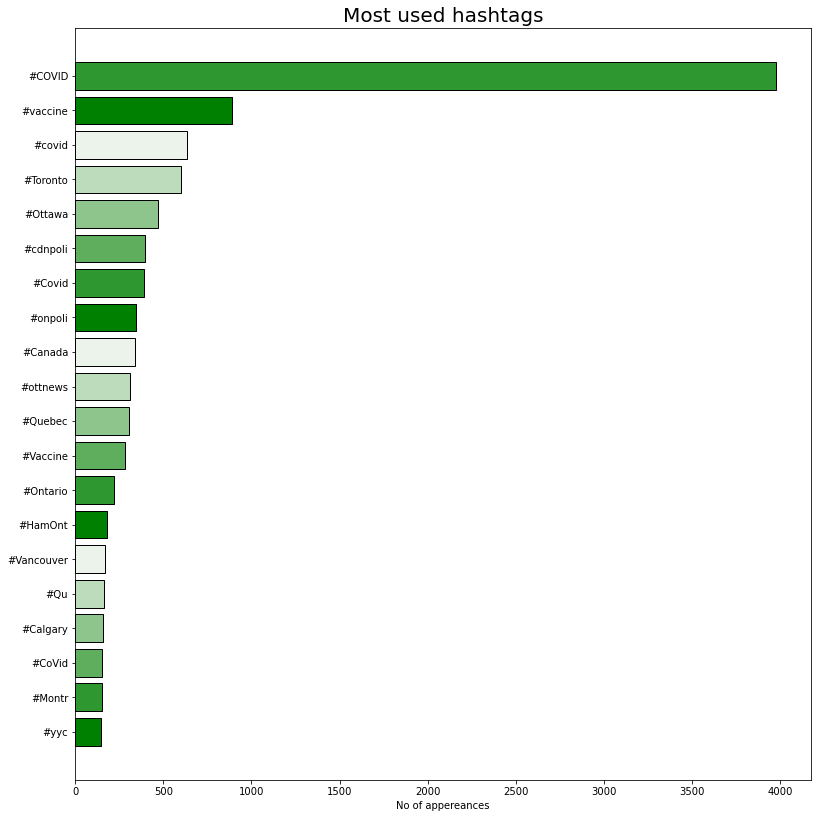

In [18]:
# Hashtag Analysis
hashtags = []
hashtag_pattern = re.compile(r"#[a-zA-Z]+")
hashtag_matches = list(df3['Tweet'].apply(hashtag_pattern.findall))
hashtag_dict = {}
for match in hashtag_matches:
    for singlematch in match:
        if singlematch not in hashtag_dict.keys():
            hashtag_dict[singlematch] = 1
        else:
            hashtag_dict[singlematch] = hashtag_dict[singlematch]+1

hashtag_ordered_list =sorted(hashtag_dict.items(), key=lambda x:x[1])
hashtag_ordered_list = hashtag_ordered_list[::-1]
#Separating the hashtags and their values into two different lists
hashtag_ordered_values = []
hashtag_ordered_keys = []
#Pick the 20 most used hashtags to plot
for item in hashtag_ordered_list[0:20]:
    hashtag_ordered_keys.append(item[0])
    hashtag_ordered_values.append(item[1])
    
fig, ax = plt.subplots(figsize = (12,12))
y_pos = np.arange(len(hashtag_ordered_keys))
ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = sns.light_palette("green", reverse=True), edgecolor = 'black', linewidth=1)
ax.set_yticks(y_pos)
ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
ax.set_xlabel("No of appereances")
ax.set_title("Most used hashtags", fontsize = 20)
plt.tight_layout(pad=3)
plt.show()